# Machine Learning Models

## Importing Libraries 📚

In [11]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import html

import warnings
warnings.filterwarnings('ignore')

## Loading Data 📕

In [10]:
anime_df = pd.read_csv('anime.csv')
anime_df_id_genre = anime_df[['anime_id', 'genre']]

## Functions 📝

In [8]:
# Converts the anime id to the name of the anime
def anime_id_to_name(anime_id):
    return anime_df[anime_df['anime_id'] == anime_id]['name'].values[0]
    
def print_animes(anime_ids, name):
    recommended_anime_data = []
    for anime_id in anime_ids:
        anime_name = anime_id_to_name(anime_id)
        anime_rating = anime_df[anime_df['anime_id'] == anime_id]['rating'].values[0]
        anime_genere = anime_df_id_genre[anime_df_id_genre['anime_id'] == anime_id]['genre'].values[0]
        recommended_anime_data.append([anime_id, anime_name, anime_rating, anime_genere])

    # Printing recommended anime table
    print("\n" + name + ":")
    print(tabulate(recommended_anime_data, headers=['Anime ID', 'Anime Name', 'Rating', 'Genere'], tablefmt='pipe'))

# Filtering Data

In [24]:
import pandas as pd

# Loads the data
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

# Removes rows with missing values
anime = anime.dropna()
rating = rating.dropna()

# Replaces non-numeric values in the episodes column with NaN
anime['episodes'] = pd.to_numeric(anime['episodes'], errors='coerce')

# Remove rows where the anime_id column contains a value that is not in the anime_id column of the anime.csv file
rating = rating[rating['anime_id'].isin(anime['anime_id'])]

## Content Based Filtering 📖

In [3]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 30.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095488 sha256=ce4ffa19d6575010d1724fd6ff92fe7b53d4ac4f5b6c3bbd07e904ff7cb2ec99
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [25]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise.model_selection import cross_validate

# Loading data in surprise
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(rating[['user_id', 'anime_id', 'rating']], reader)

# Spliting the data into training and testing sets
trainset, testset = train_test_split(data, test_size=.25)
algo = SVD()
algo.fit(trainset)
CB_predictions = algo.test(testset)
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=2, verbose=True)

# Evaluating the model using Root Mean Squared Error (RMSE)
from surprise import accuracy
accuracy.rmse(CB_predictions)

# Printing the mean RMSE and MAE over all folds
print("Mean RMSE:", results['test_rmse'].mean())
print("Mean MAE:", results['test_mae'].mean())

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    2.2809  2.2819  2.2814  0.0005  
MAE (testset)     1.6058  1.6057  1.6057  0.0000  
Fit time          62.23   63.12   62.68   0.44    
Test time         46.00   45.56   45.78   0.22    
RMSE: 2.2188
Mean RMSE: 2.281401194067046
Mean MAE: 1.6057250573313255


In [26]:
import random

def CB_recommend_anime(anime_ids, user_id=None, n=10):
    # Gets the list of all anime
    anime_list = anime[['anime_id', 'name']]
    
    # If user_id is not provided, selects a random user from the dataset
    if user_id is None:
        user_id = random.choice(rating['user_id'].unique())
    
    # Checks if the user has already watched any of the given anime_ids
    watched_anime = rating.loc[(rating['user_id'] == user_id) & rating['anime_id'].isin(anime_ids), 'anime_id']
    
    # Excluding the watched anime from the recommendations
    anime_to_exclude = list(set(watched_anime) | set(anime_ids))
    
    # Gets the list of unrated anime by the user
    unrated_anime = anime_list[~anime_list['anime_id'].isin(rating.loc[rating['user_id'] == user_id, 'anime_id'])]
    
    # Converts the unrated anime to Surprise format
    reader = Reader(rating_scale=(1, 10))
    data = Dataset.load_from_df(rating[['user_id', 'anime_id', 'rating']], reader)
    trainset = data.build_full_trainset()
    
    # Trains the model using Singular Value Decomposition (SVD)
    algo = SVD()
    algo.fit(trainset)
    predictions = []
    for index, row in unrated_anime.iterrows():
        prediction = algo.predict(user_id, row['anime_id'])
        predictions.append((prediction.est, row['anime_id'], row['name']))
    
    # Sorts the predictions by estimated rating
    predictions.sort(reverse=True)
    
    # Selects the top n anime and return the recommendations
    recommended_anime = []
    i = 0
    while len(recommended_anime) < n and i < len(predictions):
        if predictions[i][1] not in anime_to_exclude:
            recommended_anime.append(predictions[i][1])
        i += 1
    
    return recommended_anime

In [27]:
anime_ids = [20, 21, 512]
CB_recommendations = CB_recommend_anime(anime_ids, user_id=42, n=10)
print(CB_recommendations)

[32935, 11061, 9969, 5114, 4181, 3927, 2904, 2581, 1575, 918]


In [28]:
print_animes(anime_ids, "Watched Anime")
print_animes(CB_recommendations, "Recommended Anime")


Watched Anime:
|   Anime ID | Anime Name         |   Rating | Genere                                                          |
|-----------:|:-------------------|---------:|:----------------------------------------------------------------|
|         20 | Naruto             |     7.81 | Action, Comedy, Martial Arts, Shounen, Super Power              |
|         21 | One Piece          |     8.58 | Action, Adventure, Comedy, Drama, Fantasy, Shounen, Super Power |
|        512 | Majo no Takkyuubin |     8.27 | Adventure, Comedy, Drama, Fantasy, Magic, Romance               |

Recommended Anime:
|   Anime ID | Anime Name                                                |   Rating | Genere                                                       |
|-----------:|:----------------------------------------------------------|---------:|:-------------------------------------------------------------|
|      32935 | Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou |     9.15 | Comedy, Drama, 

## Collaborative Filtering (CF)

In [29]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import cross_validate

# Loads the data into a format suitable for Surprise
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(rating[['user_id', 'anime_id', 'rating']], reader)

# Splits the data into training and testing sets
trainset = data.build_full_trainset()

# Trains the model using Alternating Least Squares (ALS)
algo = SVD(biased=False, n_epochs=20, lr_all=0.005, reg_all=0.02)
algo.fit(trainset)
cf_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=2, verbose=True)

# Print the mean RMSE and MAE over all folds
print("Mean RMSE:", cf_results['test_rmse'].mean())
print("Mean MAE:", cf_results['test_mae'].mean())


Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    2.3052  2.3051  2.3051  0.0000  
MAE (testset)     1.6260  1.6244  1.6252  0.0008  
Fit time          61.51   62.40   61.96   0.44    
Test time         46.03   43.96   44.99   1.03    
Mean RMSE: 2.3051379388266526
Mean MAE: 1.625195220669292


In [30]:
import pandas as pd

# Loads the data
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

# Removes rows with missing values
anime = anime.dropna()
rating = rating.dropna()

# Replacing non-numeric values in the episodes column with NaN
anime['episodes'] = pd.to_numeric(anime['episodes'], errors='coerce')
rating = rating[rating['anime_id'].isin(anime['anime_id'])]

# Testing CF model
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import train_test_split

# Loading the data into a format suitable for Surprise
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(rating[['user_id', 'anime_id', 'rating']], reader)

# Spliting the data into training and testing sets
trainset, testset = train_test_split(data, test_size=.25)

# Training the model using Singular Value Decomposition (SVD)
algo = SVD()
algo.fit(trainset)
anime_ids = rating['anime_id'].unique()
user_id = 100

# Makes predictions for all anime that the user hasn't seen
testset = []
for anime_id in anime_ids:
    if anime_id not in rating[rating['user_id'] == user_id]['anime_id'].unique():
        testset.append((user_id, anime_id, 0))

predictions = algo.test(testset)

# Gets the top 10 recommendations
top_n = []
for uid, iid, true_r, est, _ in predictions:
    if est > 4:
        anime_name = anime[anime['anime_id'] == iid]['name'].values[0]
        top_n.append((iid, anime_name, est))

anime_ids = [32281, 2236, 16498, 287, 237, 269, 2499, 12477, 18115, 8915]
top_n = sorted(top_n, key=lambda x: x[2], reverse=True)[:10]

# Prints the top 10 recommendations
print(f"Top 10 anime recommendations for user {user_id}:")
for anime_id, anime_name, rating in top_n:
    print(f"- {anime_name} (anime_id: {anime_id}, predicted rating: {rating:.2f})")


Top 10 anime recommendations for user 100:
- Death Note (anime_id: 1535, predicted rating: 10.00)
- Fullmetal Alchemist: Brotherhood (anime_id: 5114, predicted rating: 10.00)
- Mushishi (anime_id: 457, predicted rating: 10.00)
- Ginga Eiyuu Densetsu (anime_id: 820, predicted rating: 9.95)
- Ookami Kodomo no Ame to Yuki (anime_id: 12355, predicted rating: 9.85)
- Darker than Black: Kuro no Keiyakusha (anime_id: 2025, predicted rating: 9.72)
- Kino no Tabi: The Beautiful World (anime_id: 486, predicted rating: 9.54)
- Fullmetal Alchemist (anime_id: 121, predicted rating: 9.51)
- Steins;Gate (anime_id: 9253, predicted rating: 9.47)
- Sen to Chihiro no Kamikakushi (anime_id: 199, predicted rating: 9.47)


In [21]:
print_animes(anime_ids, "Watched Anime")
print_animes([item[0] for item in top_n], "Recommended Anime")


Watched Anime:
|   Anime ID | Anime Name                                                               |   Rating | Genere                                                |
|-----------:|:-------------------------------------------------------------------------|---------:|:------------------------------------------------------|
|      32281 | Kimi no Na wa.                                                           |     9.37 | Drama, Romance, School, Supernatural                  |
|       2236 | Toki wo Kakeru Shoujo                                                    |     8.44 | Adventure, Drama, Romance, Sci-Fi                     |
|      16498 | Shingeki no Kyojin                                                       |     8.54 | Action, Drama, Fantasy, Shounen, Super Power          |
|        287 | Grappler Baki (TV)                                                       |     7.41 | Shounen, Sports                                       |
|        237 | Eureka Seven               

## Hybrid Method

In [4]:
import pandas as pd

# Loading the data
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

# Removing rows with missing values
anime = anime.dropna()
rating = rating.dropna()

# Replacing non-numeric values in the episodes column with NaN
anime['episodes'] = pd.to_numeric(anime['episodes'], errors='coerce')

# Removing rows where the anime_id column contains a value that is not in the anime_id column of the anime.csv file
rating = rating[rating['anime_id'].isin(anime['anime_id'])]


# Testing the Model
import pandas as pd
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import cross_validate

# Loading the data into a format suitable for Surprise
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(rating[['user_id', 'anime_id', 'rating']], reader)

# Spliting the data into training and testing sets
trainset = data.build_full_trainset()

# Training the model using Singular Value Decomposition (SVD)
algo = SVD(biased=False, n_epochs=20, lr_all=0.005, reg_all=0.02)
algo.fit(trainset)

# Evaluating the model using 5-fold cross-validation
hb_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=2, verbose=True)

# Printing the mean RMSE and MAE over all folds
print("Mean RMSE:", hb_results['test_rmse'].mean())
print("Mean MAE:", hb_results['test_mae'].mean())

<ipython-input-4-a2863aa70ed9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime['episodes'] = pd.to_numeric(anime['episodes'], errors='coerce')


Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    2.3270  2.3203  2.3236  0.0034  
MAE (testset)     1.6645  1.6638  1.6642  0.0003  
Fit time          8.95    9.05    9.00    0.05    
Test time         6.45    6.19    6.32    0.13    
Mean RMSE: 2.3236432992722067
Mean MAE: 1.664163729692525


In [43]:
import pandas as pd
from surprise import Dataset, Reader
from surprise import SVD
import random

# Loading the data
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

# Removing rows with missing values
anime = anime.dropna()
rating = rating.dropna()

# Replacing non-numeric values in the episodes column with NaN
anime['episodes'] = pd.to_numeric(anime['episodes'], errors='coerce')
rating = rating[rating['anime_id'].isin(anime['anime_id'])]

# Training the model
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(rating[['user_id', 'anime_id', 'rating']], reader)
trainset = data.build_full_trainset()
algo = SVD(biased=False, n_epochs=20, lr_all=0.005, reg_all=0.02)
algo.fit(trainset)

# Function to recommend anime
def recommend_anime(anime_ids, n=10):
    anime_data = anime[anime['anime_id'].isin(anime_ids)][['anime_id', 'name']]
    anime_data = anime_data.set_index('anime_id')
    recommended_anime_ids = set(anime['anime_id']) - set(anime_ids)
    recommended_anime_ids = random.sample(recommended_anime_ids, min(n, len(recommended_anime_ids)))
    anime_data['score'] = anime_data.index.map(lambda x: algo.predict(str(0), str(x)).est)
    anime_data = anime_data.sort_values(by='score', ascending=False)
    recommended_anime_data = anime[anime['anime_id'].isin(recommended_anime_ids)][['anime_id', 'name']]
    recommended_anime_data = recommended_anime_data.set_index('anime_id')
    recommended_anime_data['score'] = recommended_anime_data.index.map(lambda x: algo.predict(str(0), str(x)).est)
    recommended_anime_data = recommended_anime_data.sort_values(by='score', ascending=False)
    return pd.concat([anime_data, recommended_anime_data]).head(n)


In [44]:
anime_ids =  [32281, 2236, 16498, 287, 237, 269, 2499, 12477, 18115, 8915]
recommended_anime = recommend_anime(anime_ids, n=15)

In [74]:
print_animes(anime_ids, "Watched Anime")
print_animes(recommended_anime.index.tolist(), "Recommended Anime")


Watched Anime:
|   Anime ID | Anime Name                                                               |   Rating | Genere                                                |
|-----------:|:-------------------------------------------------------------------------|---------:|:------------------------------------------------------|
|      32281 | Kimi no Na wa.                                                           |     9.37 | Drama, Romance, School, Supernatural                  |
|       2236 | Toki wo Kakeru Shoujo                                                    |     8.44 | Adventure, Drama, Romance, Sci-Fi                     |
|      16498 | Shingeki no Kyojin                                                       |     8.54 | Action, Drama, Fantasy, Shounen, Super Power          |
|        287 | Grappler Baki (TV)                                                       |     7.41 | Shounen, Sports                                       |
|        237 | Eureka Seven               

## Evaluating Performance

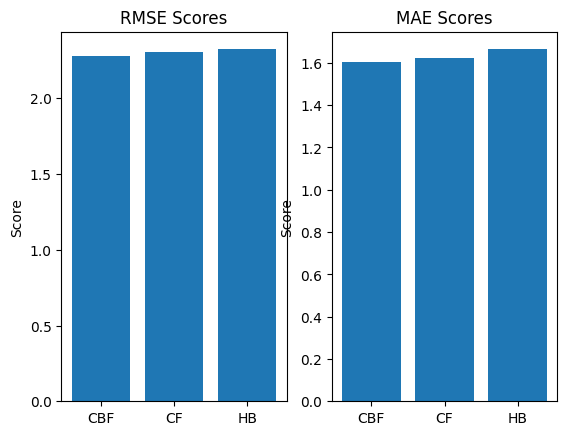

In [77]:
import matplotlib.pyplot as plt

# Extracts the RMSE and MAE scores for each model
rmse_scores = [results['test_rmse'].mean(), cf_results['test_rmse'].mean(), hb_results['test_rmse'].mean()]
mae_scores = [results['test_mae'].mean(), cf_results['test_mae'].mean(), hb_results['test_mae'].mean()]

plt.subplot(1, 2, 1)
plt.bar(['CBF', 'CF', 'HB'], rmse_scores)
plt.title('RMSE Scores')
plt.ylabel('Score')

plt.subplot(1, 2, 2)
plt.bar(['CBF', 'CF', 'HB'], mae_scores)
plt.title('MAE Scores')
plt.ylabel('Score')

plt.show()


In [79]:
best_algorithm = ''
if rmse_scores.index(min(rmse_scores)) == mae_scores.index(min(mae_scores)):
    best_algorithm = ['Content Based Filtering', 'Collaborative Filtering', 'Hybrid Model'][rmse_scores.index(min(rmse_scores))]
else:
    print("RMSE and MAE scores don't match, can't determine the best algorithm.")
print('Best algorithm by RMSE:', best_algorithm)

Best algorithm: Content Based Filtering
